In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.nonparametric import kaplan_meier_estimator
%matplotlib inline 

In [2]:
X_full = pd.read_csv('/Users/levashev/Desktop/METABRIC_RNA_Mutation.csv', low_memory=False)

In [3]:
clinical_df = X_full.iloc[:, :31]

In [4]:
clinical_df['overall_survival'].value_counts()

0    1103
1     801
Name: overall_survival, dtype: int64

In [5]:
clinical_df_inverted = clinical_df.copy()
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])
print(clinical_df_inverted.head(5))

   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal Carcinoma        High             0   
2           Breast Invasive Ductal Carcinoma        High             1   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1   
4  Breast Mixed Ductal and Lobular Carcinoma        High             1   

  pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  ...  \
0                 claudin-low     1.0       

In [6]:
KM_df = clinical_df_inverted.copy()

In [7]:
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)

Text(0.5, 0, 'time')

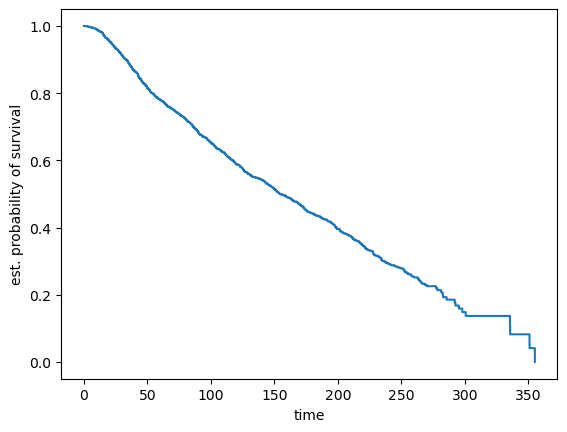

In [8]:
time, survival_prob = kaplan_meier_estimator(KM_df["overall_survival"], KM_df["overall_survival_months"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival")
plt.xlabel("time")

In [9]:
KM_df["neoplasm_histologic_grade"].value_counts()

3.0    927
2.0    740
1.0    165
Name: neoplasm_histologic_grade, dtype: int64

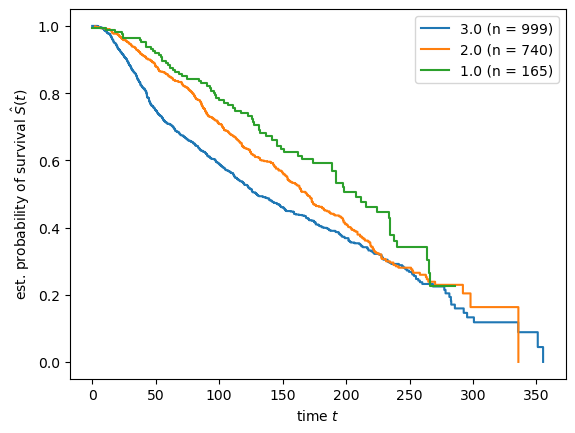

In [25]:
for value in KM_df["neoplasm_histologic_grade"].unique():
    mask = KM_df["neoplasm_histologic_grade"] == value
    time_grade, survival_prob_grade = kaplan_meier_estimator(KM_df["overall_survival"][mask],
                                                           KM_df["overall_survival_months"][mask])
    plt.step(time_grade, survival_prob_grade, where="post",
             label="%s (n = %d)" % (value, mask.sum()))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [11]:
KM_df.drop(['patient_id', 'cohort'], axis=1, inplace=True)

In [12]:
KM_df = KM_df.fillna(KM_df.median())

/var/folders/vh/hc2rrhwj2815q2zt0v5kkzlw0000gn/T/ipykernel_47159/666758486.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  KM_df = KM_df.fillna(KM_df.median())


In [13]:
num_columns = [cname for cname in KM_df.columns if 
                KM_df[cname].dtype in ['int64', 'float64']]
print(num_columns)

['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'overall_survival_months', 'radio_therapy', 'tumor_size', 'tumor_stage']


In [14]:
cat_columns = [cname for cname in KM_df.columns if
                    KM_df[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer']


In [15]:
my_columns = cat_columns + num_columns

In [16]:
KM_df_dum = pd.get_dummies(KM_df, columns = cat_columns)
KM_df_dum.head(5)

,age_at_diagnosis,chemotherapy,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,...,oncotree_code_MDLC,pr_status_Negative,pr_status_Positive,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+,death_from_cancer_Died of Disease,death_from_cancer_Died of Other Causes,death_from_cancer_Living
0,75.65,0,3.0,1,10.0,5.0,6.044,140.500000,False,1,...,0,1,0,0,0,1,0,0,0,1
1,43.19,0,3.0,1,0.0,2.0,4.020,84.633333,False,1,...,0,0,1,1,0,0,0,0,0,1
2,48.87,1,2.0,1,1.0,2.0,4.030,163.700000,True,0,...,0,0,1,0,0,0,0,1,0,0
3,47.68,1,2.0,1,3.0,1.0,4.050,164.933333,False,1,...,1,0,1,0,0,0,0,0,0,1
4,76.97,1,3.0,1,8.0,2.0,6.080,41.366667,True,1,...,1,0,1,1,0,0,0,1,0,0


In [17]:
KM_df_y = KM_df.copy()

In [18]:
KM_df.columns

Index(['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

In [19]:
KM_df_y.drop(['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'], axis=1, inplace=True)

In [20]:
print(KM_df_y)

      overall_survival_months  overall_survival
0                  140.500000             False
1                   84.633333             False
2                  163.700000              True
3                  164.933333             False
4                   41.366667              True
...                       ...               ...
1899               196.866667             False
1900                44.733333              True
1901               175.966667              True
1902                86.233333              True
1903               201.900000              True

[1904 rows x 2 columns]


In [21]:
KM_df_y_rear = KM_df_y[['overall_survival', 'overall_survival_months']]
print(KM_df_y_rear)

      overall_survival  overall_survival_months
0                False               140.500000
1                False                84.633333
2                 True               163.700000
3                False               164.933333
4                 True                41.366667
...                ...                      ...
1899             False               196.866667
1900              True                44.733333
1901              True               175.966667
1902              True                86.233333
1903              True               201.900000

[1904 rows x 2 columns]


In [22]:
new_KM = KM_df_y_rear[['overall_survival', 'overall_survival_months']].to_numpy()
print(new_KM)

[[False 140.5]
 [False 84.63333333]
 [True 163.7]
 ...
 [True 175.9666667]
 [True 86.23333333]
 [True 201.9]]


In [23]:
#Делаем структурированный массив
dt=dtype=[('Status', '?'), ('Survival_in_days', '<f8')]

#Structured array
struct_KM = np.array([tuple(row) for row in new_KM], dtype=dt)
struct_KM

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [40]:
KM_df_x_num = KM_df_x.copy()
KM_df_x_num.drop(['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 
                  'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 
                  'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 
                  'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 
                  'oncotree_code', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer'], axis=1, inplace=True)
KM_df_x_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_at_diagnosis               1904 non-null   float64
 1   chemotherapy                   1904 non-null   int64  
 2   neoplasm_histologic_grade      1904 non-null   float64
 3   hormone_therapy                1904 non-null   int64  
 4   lymph_nodes_examined_positive  1904 non-null   float64
 5   mutation_count                 1904 non-null   float64
 6   nottingham_prognostic_index    1904 non-null   float64
 7   radio_therapy                  1904 non-null   int64  
 8   tumor_size                     1904 non-null   float64
 9   tumor_stage                    1904 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 148.9 KB


In [41]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(KM_df_x_num, struct_KM)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [42]:
pd.Series(estimator.coef_, index=KM_df_x_num.columns)

age_at_diagnosis                 0.040291
chemotherapy                     0.366882
neoplasm_histologic_grade        0.085004
hormone_therapy                 -0.113805
lymph_nodes_examined_positive    0.041925
mutation_count                   0.002712
nottingham_prognostic_index      0.132634
radio_therapy                   -0.274418
tumor_size                       0.006705
tumor_stage                      0.190613
dtype: float64